**INSTALLING MODULES**

In [ ]:
# Install and authenticate Google Earth Engine
!pip install earthengine-api
!earthengine authenticate

In [ ]:
!pip install geemap

In [ ]:
!pip install rasterio

In [ ]:
!pip install selenium
!apt-get update
!apt install -y chromium-chromedriver
!cp /usr/lib/chromium-browser/chromedriver /usr/bin

import sys
sys.path.insert(0,'/usr/lib/chromium-browser/chromedriver')

**LOADING MODULES**

In [ ]:

import ee
import pandas as pd
import geemap
from PIL import Image, ImageDraw, ImageFont
import os
import matplotlib.pyplot as plt
from osgeo import gdal
import rasterio
import numpy as np
import folium
from folium import raster_layers
from selenium import webdriver

In [ ]:
# Initialize Google Earth Engine
ee.Initialize()

In [ ]:
# Define the region of interest: Chocó-Darién Rainforest
roi = ee.Geometry.Polygon(
        [[[-78.31, 8.56],
          [-76.19, 8.56],
          [-76.19, 7.34],
          [-78.31, 7.34]]])

In [ ]:
# Create an interactive map
Map = geemap.Map()

# Set the map center to the ROI with a specific zoom level (e.g., 6)
Map.centerObject(roi, 6)

# Add the ROI to the map with a specific color (e.g., red)
Map.addLayer(roi, {'color': 'red'}, 'ROI')

# Display the map
Map

Map(center=[7.951040667559652, -77.2500000000001], controls=(WidgetControl(options=['position', 'transparent_b…

In [ ]:
# Load the Hansen Global Forest Change dataset
dataset = ee.Image("UMD/hansen/global_forest_change_2019_v1_7")

In [ ]:
# Get band names
band_names = dataset.bandNames().getInfo()

print(band_names)

['treecover2000', 'loss', 'gain', 'lossyear', 'first_b30', 'first_b40', 'first_b50', 'first_b70', 'last_b30', 'last_b40', 'last_b50', 'last_b70', 'datamask']


In [ ]:
# Extract the 'lossyear' band which represents the year of loss.
lossyear = dataset.select(['lossyear'])

In [ ]:
# Create a dictionary to store results.
loss_data = {}

# Area of each pixel in hectares.
pixel_area = 0.09

# Loop through each year from 2001 to 2019.
for year in range(1, 18):
    # Create a mask for forest loss for the specific year.
    loss_mask = lossyear.eq(year)

    # Calculate the number of pixels that experienced loss in that year.
    loss_pixel_count = loss_mask.reduceRegion(
        reducer=ee.Reducer.sum(),
        geometry=roi,
        scale=30,  # The dataset has a resolution of 30m.
        maxPixels=1e9
    ).get('lossyear').getInfo()

    # Convert pixel count to area in hectares.
    loss_area_hectares = loss_pixel_count * pixel_area

    # Store the result in the dictionary.
    loss_data[year + 2000] = loss_area_hectares

In [ ]:
# Convert the dictionary to a pandas dataframe.
df = pd.DataFrame(list(loss_data.items()), columns=['Year', 'Loss_Area_Hectares'])

print(df)

In [ ]:
# Export to CSV
df.to_csv('Deforestation.csv', index=False)


**Calculate the yearly forest loss again to visualize on the map**

In [ ]:
## we are visualizing at a much coarser scale. not 30m by 30m.
## This is because geemap has a pixel limit for images generated


# Initialize the Earth Engine module
ee.Initialize()

# Define the region of interest: Chocó-Darién Rainforest
roi = ee.Geometry.Polygon(
        [[[-78.31, 8.56],
          [-76.19, 8.56],
          [-76.19, 7.34],
          [-78.31, 7.34]]])

# Load the Hansen Global Forest Change dataset
dataset = ee.Image("UMD/hansen/global_forest_change_2019_v1_7")

# Area of each pixel in hectares for the new scale of 2000 meters.
pixel_area = 400  # 2000m x 2000m = 4,000,000 m^2 = 400 hectares

# Function to get forest loss data for a specific year and return the loss in hectares
def get_forest_loss(year):
    # Extract the 'lossyear' band which represents the year of loss.
    lossyear = dataset.select(['lossyear'])

    # Create a mask for forest loss for the specific year.
    loss_mask = lossyear.eq(year)

    # Convert binary mask to loss in hectares for each pixel
    loss_hectares_image = loss_mask.multiply(pixel_area)

    # Calculate the total loss in hectares for the region
    total_loss_hectares = loss_hectares_image.reduceRegion(
        reducer=ee.Reducer.sum(),
        geometry=roi,
        scale=2000,  # Adjusted scale
        maxPixels=1e9
    ).get('lossyear').getInfo()

    return loss_hectares_image, total_loss_hectares

# Export each yearly forest loss image
image_list = []
for year in range(1, 18):  # From 2001 to 2018
    loss_image, loss_hectares = get_forest_loss(year)
    out_path = f'/content/Loss_{year+2000}.tif'
    geemap.ee_export_image(loss_image, filename=out_path, scale=2000, region=roi, file_per_band=False)  # Updated scale
    image_list.append((out_path, loss_hectares))



**Checking bands**

In [ ]:
def check_bands_of_image(image_path):
    # Open the image using GDAL
    ds = gdal.Open(image_path)

    # Check if the dataset was opened successfully
    if ds is None:
        print(f"Failed to open the image: {image_path}")
        return

    # Get the number of bands
    num_bands = ds.RasterCount
    print(f"Number of bands in the image: {num_bands}")

    # Print band details
    for i in range(1, num_bands + 1):
        band = ds.GetRasterBand(i)

        # Some raster formats will have band names, but not all
        # If the format doesn't support band names, it'll return None
        band_name = band.GetDescription()

        if band_name:
            print(f"Band {i}: {band_name}")
        else:
            print(f"Band {i}")

# Example usage
image_path = "/content/Loss_2001.tif"  # Image path
check_bands_of_image(image_path)

Number of bands in the image: 1
Band 1


**Visualize the data on a map**


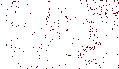


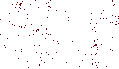


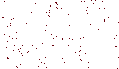


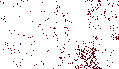


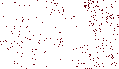


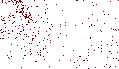


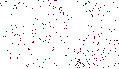


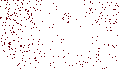


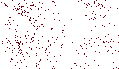


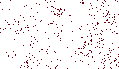


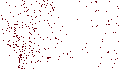


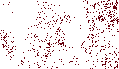


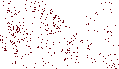


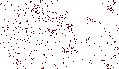


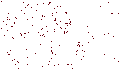


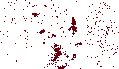


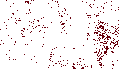

In [ ]:


# Function to overlay a GeoTIFF on a folium map
def add_geotiff_to_map(m, img_path, colormap, vmin=0, vmax=400, opacity=0.6):
    with rasterio.open(img_path) as src:
        # Get bounds of the image
        bounds = src.bounds
        # Read the image data
        data = src.read(1)
        # Normalize the data to fit within the range [0, 1]
        norm_data = (data - vmin) / (vmax - vmin)
        # Apply the colormap to the normalized data to get an RGB image
        colored_data = (colormap(norm_data)[:, :, :3] * 255).astype(np.uint8)
        # Use folium's rasters method to overlay the image on the map
        raster_layers.ImageOverlay(
            image=colored_data,
            bounds=[[bounds.bottom, bounds.left], [bounds.top, bounds.right]],
            opacity=opacity
        ).add_to(m)

# Define a colormap
colormap = plt.cm.Reds

# Create a list to store the maps
maps = []

# Overlay the GeoTIFFs on individual maps
for year in range(2001, 2018):  # Year range
    m = folium.Map(location=[8, -77.25], zoom_start=8, tiles='Stamen Terrain')  # Location to Chocó-Darién Rainforest
    img_path = f'/content/Loss_{year}.tif'  # Image path
    add_geotiff_to_map(m, img_path, colormap)
    maps.append(m)

# Display the maps
for m in maps:
    display(m)


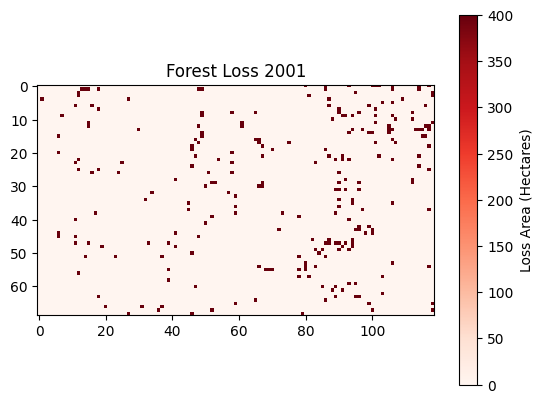

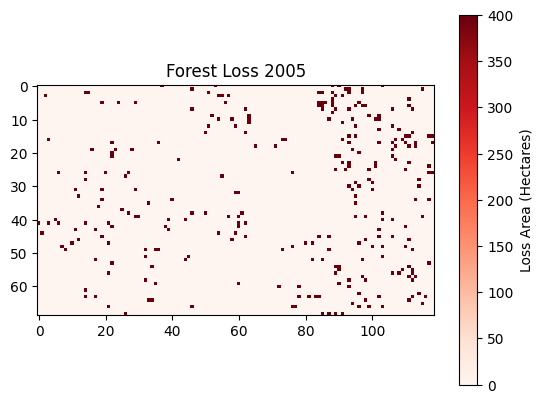

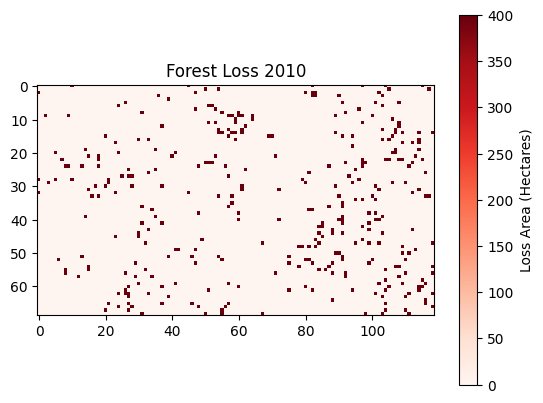

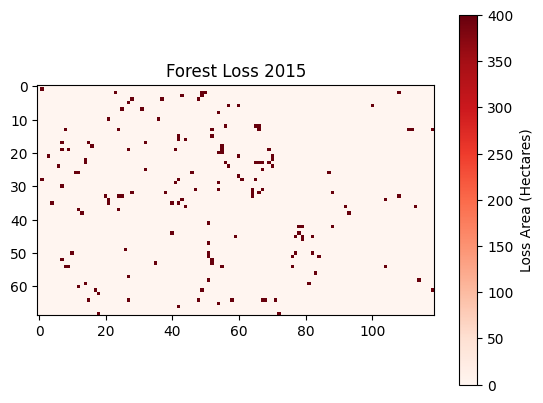

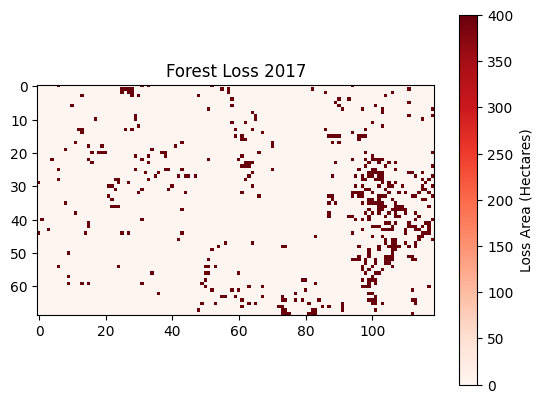

In [ ]:
# Visualize a few of the images with matplotlib
years_to_check = [2001, 2005, 2010, 2015, 2017]  e

for year in years_to_check:
    img_path = f'/content/Loss_{year}.tif'
    ds = gdal.Open(img_path)

    if ds is None:
        print(f"Failed to open the image: {img_path}")
        continue

    band = ds.GetRasterBand(1)
    arr = band.ReadAsArray()

    # Plot the image
    plt.imshow(arr, cmap='Reds')
    plt.title(f'Forest Loss {year}')
    plt.colorbar(label='Loss Area (Hectares)')
    plt.show()

**Create png images that show the estimated forest coverage loss on the map**

In [ ]:


# Function to overlay a GeoTIFF on a folium map
def add_geotiff_to_map(m, img_path, colormap, vmin=0, vmax=400, opacity=0.6):
    with rasterio.open(img_path) as src:
        bounds = src.bounds
        data = src.read(1)
        norm_data = (data - vmin) / (vmax - vmin)
        colored_data = (colormap(norm_data)[:, :, :3] * 255).astype(np.uint8)
        raster_layers.ImageOverlay(
            image=colored_data,
            bounds=[[bounds.bottom, bounds.left], [bounds.top, bounds.right]],
            opacity=opacity
        ).add_to(m)

# Define a colormap
colormap = plt.cm.Reds

chrome_options = webdriver.ChromeOptions()
chrome_options.add_argument('--headless')
chrome_options.add_argument('--no-sandbox')
chrome_options.add_argument('--disable-dev-shm-usage')

def save_folium_map_as_image(m, filename, year):
    tmp_path = "temp_map.html"
    m.save(tmp_path)
    browser = webdriver.Chrome(options=chrome_options)
    browser.get(f"file://{os.getcwd()}/{tmp_path}")
    browser.save_screenshot(filename)
    browser.quit()

    # Crop the saved image and add the year label
    with Image.open(filename) as img:
        # Define crop coordinates (left, upper, right, lower)
        # Adjust these values as needed
        cropped_img = img.crop((100, 100, 700, 500))

        # Add the year label to the cropped image
        draw = ImageDraw.Draw(cropped_img)
        font = ImageFont.load_default()
        draw.text((20, 20), str(year), font=font, fill="black")

        cropped_img.save(filename)

maps = []

# Adjusted the range of years and the location coordinates
for year in range(2001, 2018):
    m = folium.Map(location=[8, -77.25], zoom_start=8, tiles='Stamen Terrain')
    img_path = f'/content/Loss_{year}.tif'
    add_geotiff_to_map(m, img_path, colormap)
    maps.append(m)
    save_folium_map_as_image(m, f'Loss_{year}.png', year)



**Creating a GIF with the generated PNG images**

In [ ]:
# Directory where the images are saved
image_dir = '/content/'

# List to store the images
images = []

# Loop through each year and read the images
# Adjusted the range of years
for year in range(2001, 2018):
    image_path = os.path.join(image_dir, f'Loss_{year}.png')

    # Open the image using PIL
    img = Image.open(image_path)

    # Add the year label to the image
    draw = ImageDraw.Draw(img)
    font = ImageFont.load_default()
    draw.text((20, 20), str(year), font=font, fill="black")

    # Append to the images list
    images.append(img)

# Update the output GIF filename
out_gif_path = os.path.join(image_dir, 'ForestLoss_timelapse.gif')
images[0].save(out_gif_path, save_all=True, append_images=images[1:], loop=0, duration=1000)